# Image Processing Accuracy and Performance Metrics Analysis

- Obtain the performance metrics for the image processing nodule detection algorithm

- To calculate performance metrics:
1. Randomly select a patient from dataset.
2. Query the patient's manually annotated nodules from pylidc.
3. Use IP software to obtain automatically detected nodules from the patient's lung CT scan stack
4. Compare results and note down the True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives (FN).
5. Calculate performance metrics based on their formulas (as shown in final report methodology)

- Analyse results of IP nodule detection algorithm by observing and recording its accuracy, specificity, precision and sensitivity

- For detailed comments for image processing software code, please refer to ip_software.ipynb

In [1]:
# Import necessary modules and packages
import os
import numpy as np
import pydicom
import cv2
import PIL
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from skimage import segmentation
from sklearn.cluster import KMeans

# Functions below are used for generating IP software results 

- Refer to IP software code script for detailed function comments

In [2]:
def load_scan(path):
    
    scans = []
    for pth, dirs, files in os.walk(path):
        for filename in files:
            if ".dcm" in filename: 
                scans.append(os.path.join(pth,filename))
        
    slices = [pydicom.read_file(s) for s in scans]
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [3]:
# median filter
def median_filter(img, display=False, footprint=0):
    temp = scipy.ndimage.median_filter(img,2)
    if (display):
        plt.axis('off')
        plt.imshow(temp,cmap='gray')
    return temp

In [4]:
# Segmentation and thresholding
def thresholding(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    return dilation

In [5]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def acwe_morph(img, display=False):
    
    init_ls = segmentation.checkerboard_level_set(img.shape, 6)
    evolution = []
    callback = store_evolution_in(evolution)
    ls = segmentation.morphological_chan_vese(img, 35, init_level_set=init_ls, smoothing=3,
                                 iter_callback=callback)

    if display: 
        plt.axis('off')
        plt.imshow(ls, cmap="gray")
        contour = plt.contour(evolution[2], [0.5], colors='g')
        contour.collections[0].set_label("Iteration 2")
        contour = plt.contour(evolution[7], [0.5], colors='y')
        contour.collections[0].set_label("Iteration 7")
        contour = plt.contour(evolution[-1], [0.5], colors='r')
        contour.collections[0].set_label("Iteration 35")
        
    return ls
    

In [6]:
def get_nodule(img, display=False, explain=False):
    second_img = img
    second_img = acwe_morph(thresholding(median_filter(second_img)))

    label_img = measure.label(second_img)
    regions = measure.regionprops(label_img)

    if display:
        fig, ax = plt.subplots()
        ax.imshow(label_img)

    im_border = segmentation.clear_border(second_img, buffer_size=5)
    
    if display:
        plt.imshow(im_border)

    label_img = measure.label(im_border)
    regions = measure.regionprops(im_border)
    
    for props in regions:
        equivalent_diameter = props.equivalent_diameter*0.2645833333
        diameter = props.major_axis_length*0.2645833333
        if display:
            print("Area of nodule is (mm^2)" ,props.area*0.2645833333*0.2645833333, "\nDiameter of nodule is (mm)",diameter)
            print("solidity: ", props.solidity)
            print("spiculation: ", diameter-equivalent_diameter)
        if explain:
            spiky = diameter-equivalent_diameter
            area, diam, solid = props.area*0.2645833333*0.2645833333, diameter, props.solidity
            return im_border, area, diam, solid, spiky
            
    
    return im_border

In [7]:
def show_nodules(img, new_img, display=False): 
    
    contours = measure.find_contours(new_img, 0.8)
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.75, color='red')
    
    if display:
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
    else:
        return plt

In [27]:
def cnn_process(second_img):
    
    label_img = measure.label(second_img)
    regions = measure.regionprops(label_img)

    im_border = segmentation.clear_border(second_img, buffer_size=5)

    label_img = measure.label(im_border)
    regions = measure.regionprops(im_border)
    
    area_coords = []
    
    for props in regions:
        if 0 < props.area < 20000 and props.solidity > 0.90:
            area_coords.append(props.coords.tolist())
    
    result = []
       
    for nodule in area_coords:
        max_x = nodule[0][0]
        min_x = nodule[0][0]
        max_y = nodule[0][1]
        min_y = nodule[0][1]

        for x,y in nodule:
            if x < min_x:
                min_x = x
            if x > max_x:
                max_x = x
            if y < min_y:
                min_y = y
            if y > max_y:
                max_y = y
        result.append([max_x, min_x, max_y, min_y])

    
    return result

In [38]:
def get_nodule_stack(nodule_coords, img):
    
    img_stack = []
    
    for max_y, min_y, max_x, min_x in nodule_coords:
        
        pad_up = 25 
        pad_down = 25
        pad_left = 25 
        pad_right = 25 
        
        img_stack.append(median_filter(img[min_y - pad_down :max_y + pad_up, min_x - pad_up:max_x +pad_right], False, 1))    
    
    return img_stack

In [10]:
def get_all(imgs_after_resamp):   
    all_nodule_slices = []
    only_nodule_slices = []

    for img in imgs_after_resamp[15:]:
        second_img = acwe_morph(thresholding(median_filter(img)))
        all_nodule_slices.append(second_img)
        nodule_coords = cnn_process(second_img) 
        if len(nodule_coords) > 0:
            img_stack = get_nodule_stack(nodule_coords, img)
            for image in img_stack:
                only_nodule_slices.append([image, img])
                
    return only_nodule_slices

In [11]:
def preprocess_patient(data_path):
    
    patient = load_scan(data_path)
    imgs = get_pixels_hu(patient)

    imgs_to_process = imgs

    only_nodule_slices = get_all(imgs_to_process)
    
    return only_nodule_slices

In [67]:
def sample_stack(stack, rows=2):
    size = len(stack)
    if size % 2 == 0:
        cols = size//2
    else: 
        cols = size//2 + 1
    fig,ax = plt.subplots(cols, rows, figsize=[12,15])
    for i in range(rows*cols):
        if i < size:
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % (i+1))
            ax[int(i/rows),int(i % rows)].imshow(stack[i][0],cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

In [55]:
# rule-based system
def rule_based(img, i):
    
    zoomed_in = img[0]
    original = img[1]
    
    fig,ax = plt.subplots(1, 2, figsize=[10,40])
    
    ax[0].set_title('slice %d : zoomed-in nodule' % (i+1))
    ax[0].imshow(zoomed_in,cmap='gray')
    ax[0].axis('off')

    new_img, area, diameter, solidity, spiculation= get_nodule(original, False, True)
    contours = measure.find_contours(new_img, 0.8)

    ax[1].set_title('slice %d : highlighted nodule' % (i+1))
    ax[1].imshow(original,cmap='gray')
    ax[1].axis('off')

    for n, contour in enumerate(contours):
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
        
    plt.show()
    
    if diameter >= 3 and spiculation > 0.1:
        print("Nodule is strongly speculated to be malignant because diameter of nodule >=3mm and its spiculation is spiky")
    else:
        if diameter<3:
            print("Nodule may be malignant because its spiculation is spiky but diameter is <3mm")
        else:
            print("Nodule may be malignant because its diamter is >=3mm but its spiculation is not spiky")
    
    print("Area of Nodule:", area)
    print("Diameter of Nodule:", diameter)
    print("Solidity of Nodule:", solidity)
    print("Spiculation:", spiculation)
    

# Functions below are used for querying manually annotated nodules
- query manually annotated nodules from PYLIDC to compare results

In [13]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

In [32]:
def show_all_nodules(pid, n):
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    
    nods = scan.cluster_annotations()
    
    all_nodules = pl.query(pl.Annotation).join(pl.Scan)\
             .filter(pl.Scan.patient_id == pid)

    length = all_nodules.count()
    print(length)

    ind = 0
    fig,ax = plt.subplots(1,length,figsize=(40,30))

    for x in all_nodules:
        vol = x.scan.to_volume()
        print(x.scan)

        padding = [(30,10), (10,25), (0,0)]
        bbox = x.bbox(pad=padding)

        ax[ind].imshow(vol[bbox][:,:,n], cmap=plt.cm.gray)
        ax[ind].axis('off')
        ind += 1

In [64]:
def get_average_annotation(anns):
    
    malignancy = 0
    spiculation = 0
    area = 0
    diam = 0
    for ann in anns:
        malignancy += ann.malignancy
        spiculation += ann.spiculation
        diam += ann.diameter
        area += ann.surface_area
    
    n = len(anns)
    
    m,s,a,d = malignancy/n, spiculation/4, area/4, diam/4
    
    print("Malignancy: ", m)
    print("Spiculation: ", s)

# Patient ID 0001

4
Loading dicom files ... This may take a moment.
Scan(id=12,patient_id=LIDC-IDRI-0001)
Loading dicom files ... This may take a moment.
Scan(id=12,patient_id=LIDC-IDRI-0001)
Loading dicom files ... This may take a moment.
Scan(id=12,patient_id=LIDC-IDRI-0001)
Loading dicom files ... This may take a moment.
Scan(id=12,patient_id=LIDC-IDRI-0001)


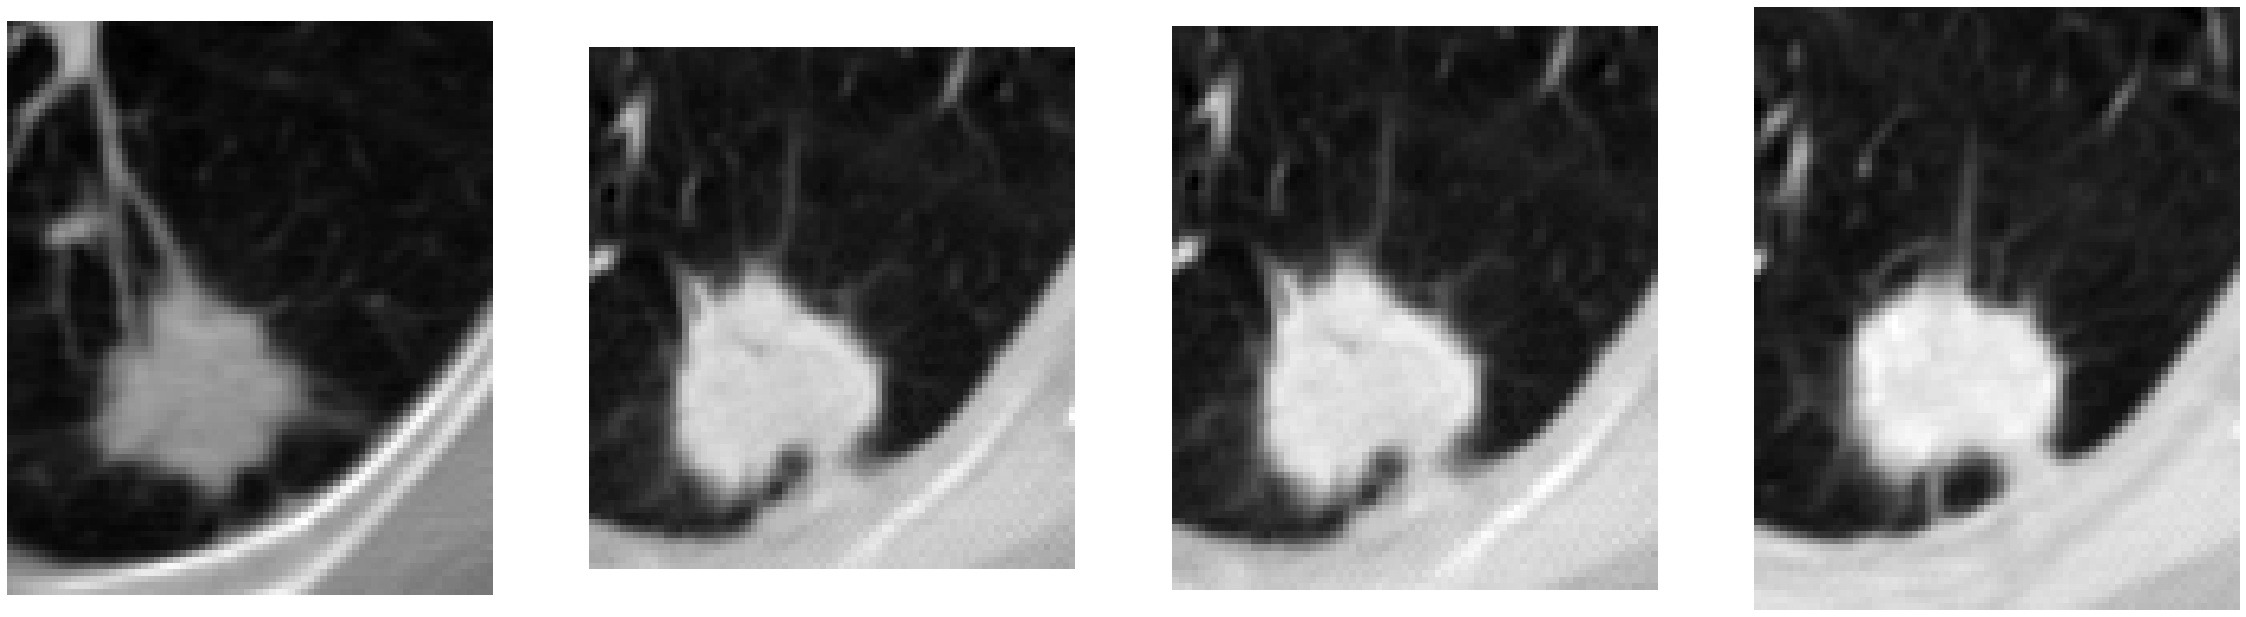

In [15]:
pid = 'LIDC-IDRI-0001'
show_all_nodules(pid, 1)

5


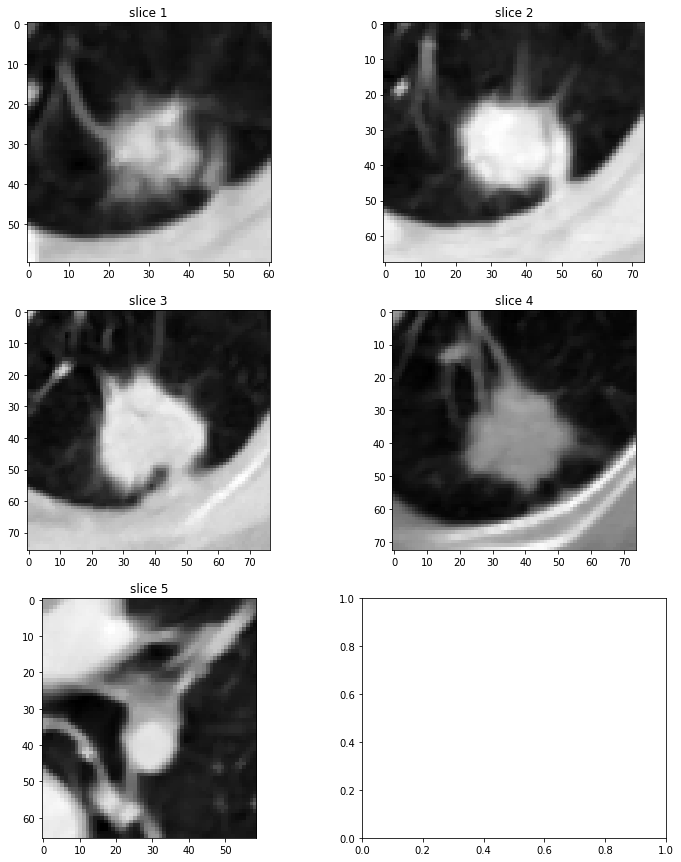

In [16]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192"
only_nodule_slices = preprocess_patient(data_path)
print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

# Patient ID 0115

4
Loading dicom files ... This may take a moment.
Scan(id=6,patient_id=LIDC-IDRI-0115)
Loading dicom files ... This may take a moment.
Scan(id=6,patient_id=LIDC-IDRI-0115)
Loading dicom files ... This may take a moment.
Scan(id=6,patient_id=LIDC-IDRI-0115)
Loading dicom files ... This may take a moment.
Scan(id=6,patient_id=LIDC-IDRI-0115)


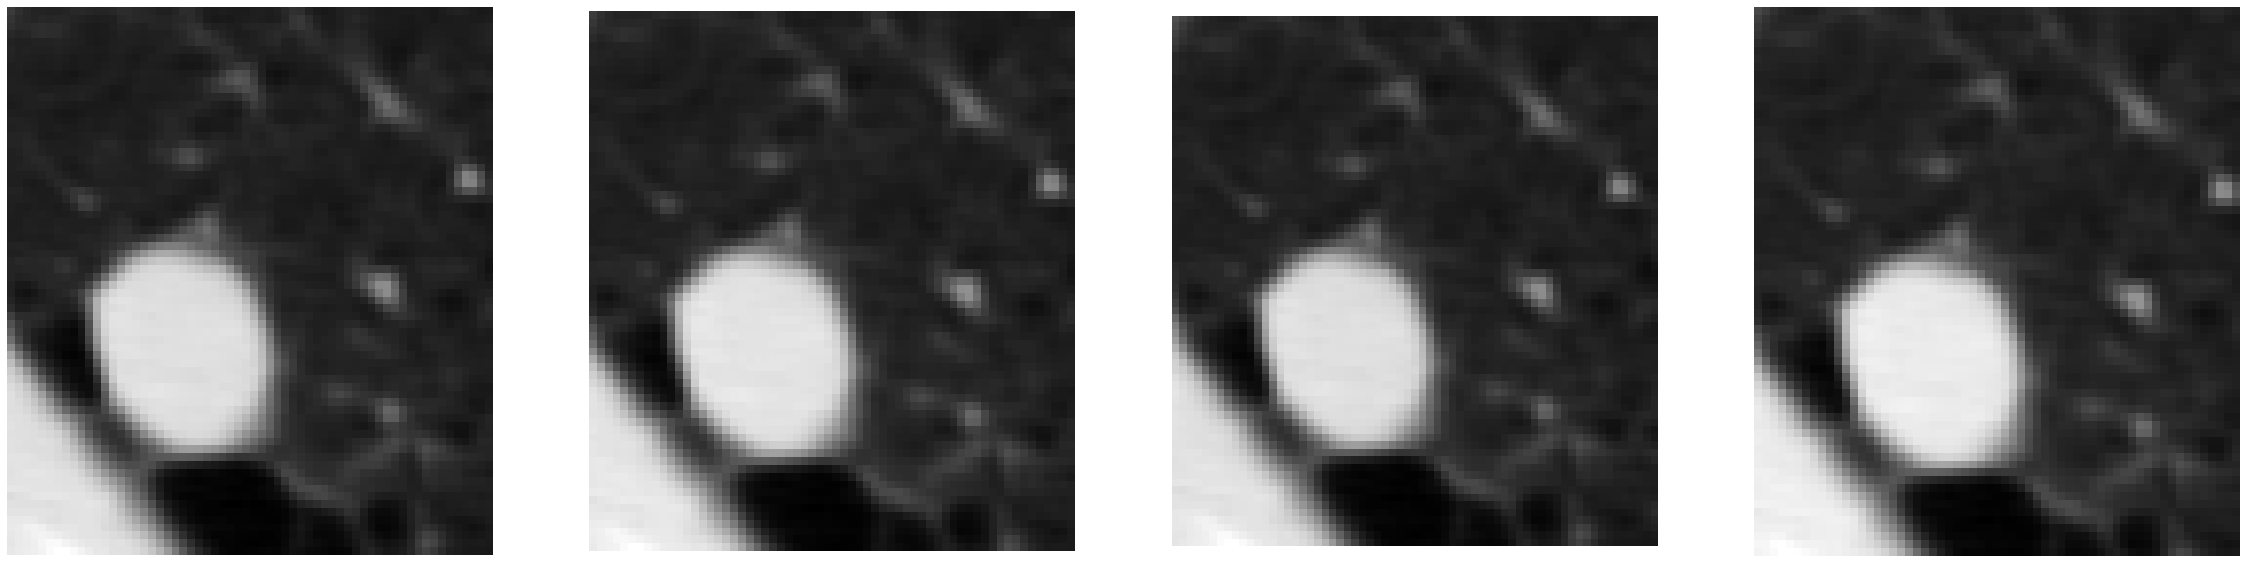

In [33]:
pid = 'LIDC-IDRI-0115'
show_all_nodules(pid, 4) #4/5

In [39]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0115/01-01-2000-06680/3236.000000-37997"
only_nodule_slices = preprocess_patient(data_path)

4


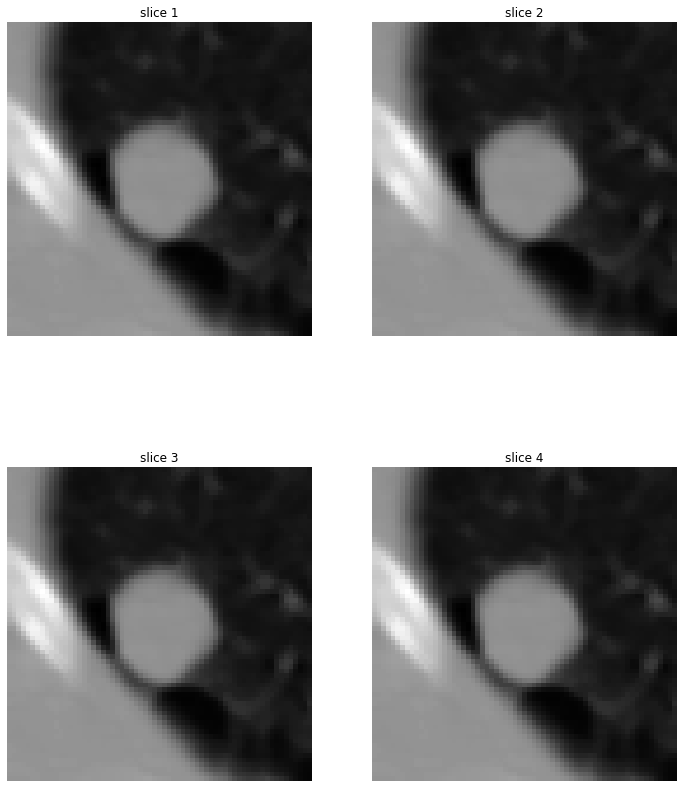

In [40]:
print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

# Patient ID 0014

4
Loading dicom files ... This may take a moment.
Scan(id=25,patient_id=LIDC-IDRI-0014)
Loading dicom files ... This may take a moment.
Scan(id=25,patient_id=LIDC-IDRI-0014)
Loading dicom files ... This may take a moment.
Scan(id=25,patient_id=LIDC-IDRI-0014)
Loading dicom files ... This may take a moment.
Scan(id=25,patient_id=LIDC-IDRI-0014)


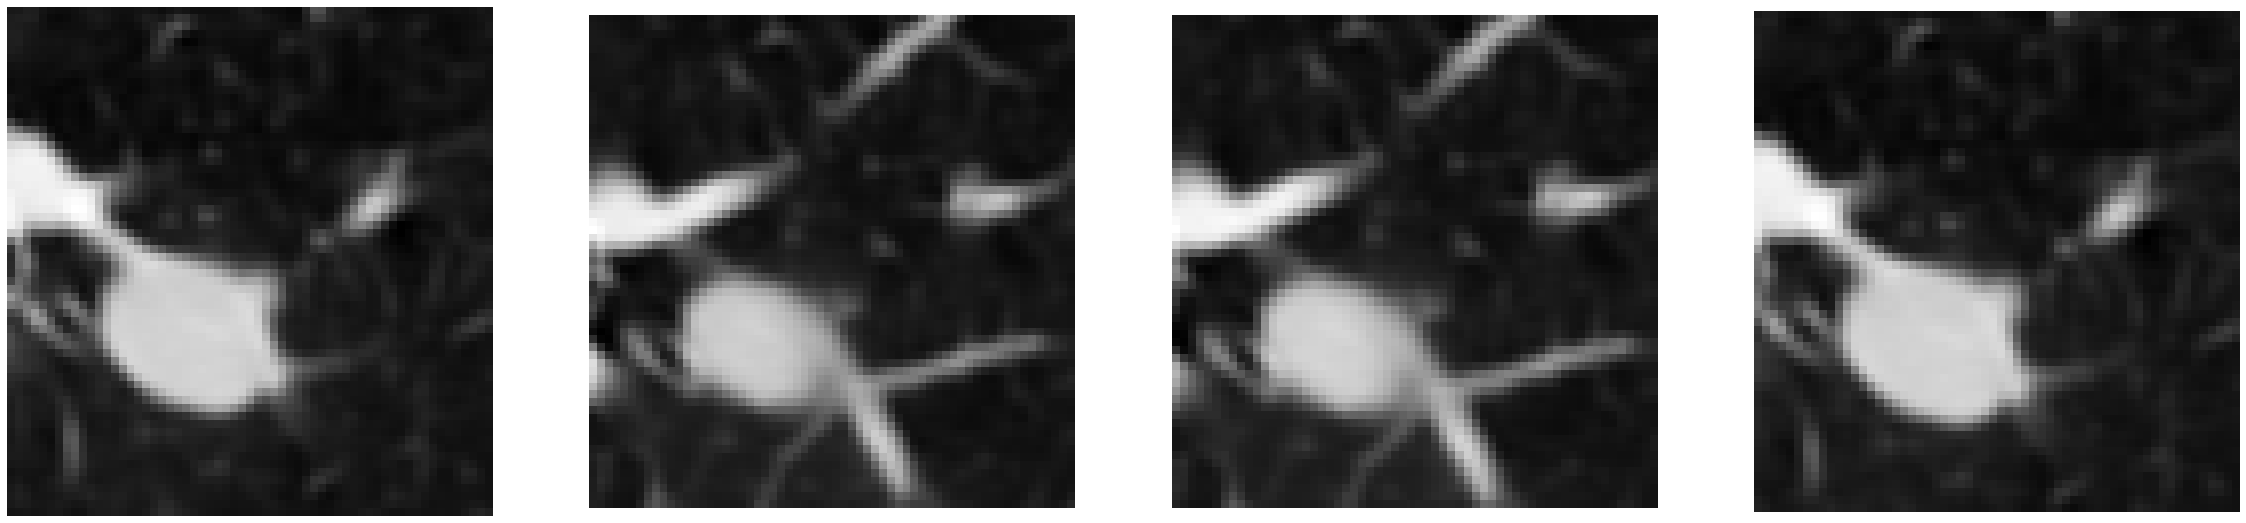

In [47]:
pid = 'LIDC-IDRI-0014'
show_all_nodules(pid, 3) #2/3/

In [42]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0014/01-01-2000-38612/3000562.000000-07402"
only_nodule_slices = preprocess_patient(data_path)

3


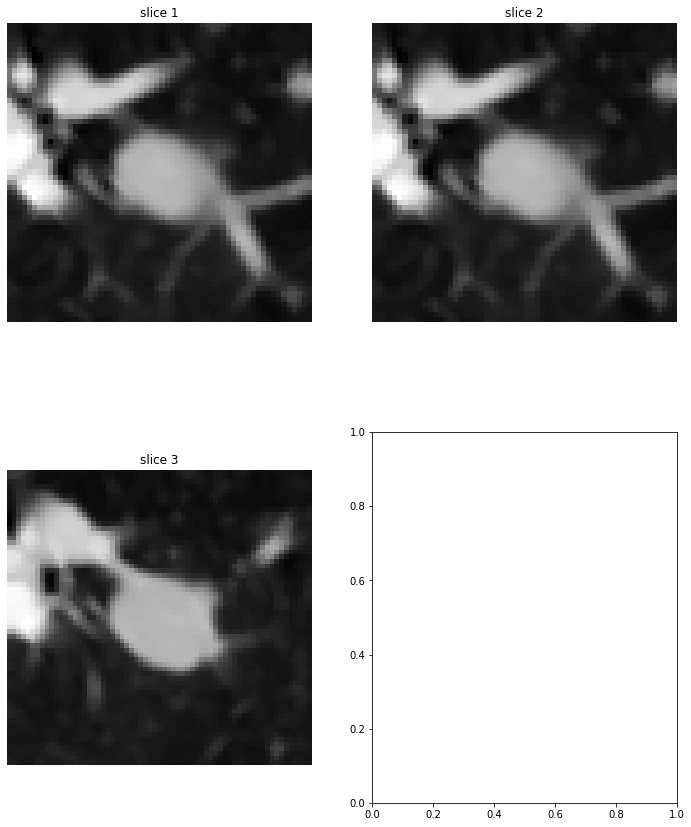

In [50]:
print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

# Patient ID 0078

13
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,patient_id=LIDC-IDRI-0078)
Loading dicom files ... This may take a moment.
Scan(id=1,pati

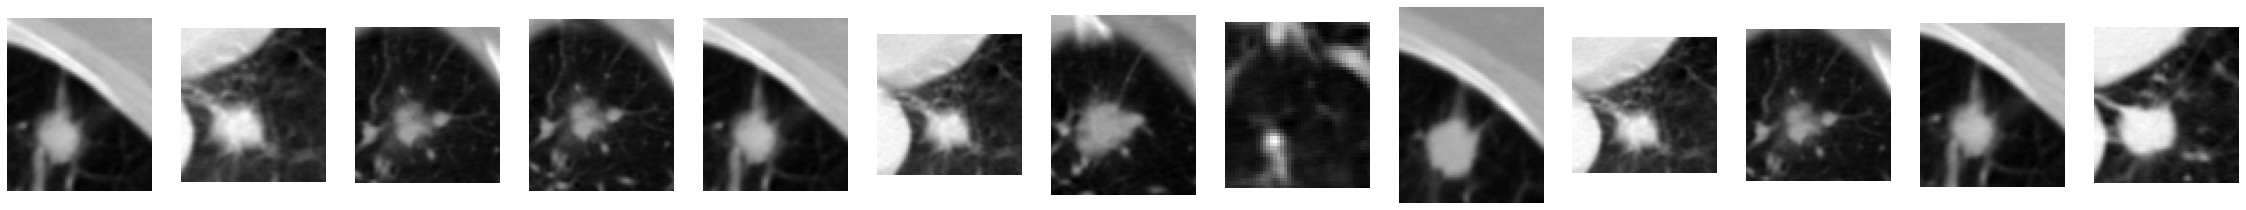

In [52]:
pid = 'LIDC-IDRI-0078'
show_all_nodules(pid, 1)

10


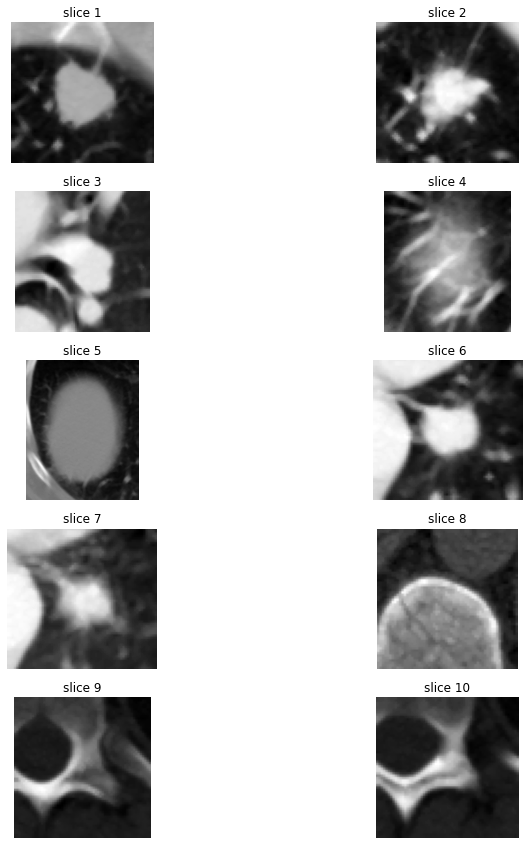

In [53]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0078/01-01-2000-68432/3165.000000-53824"
only_nodule_slices = preprocess_patient(data_path)
print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

# Patient ID 0018

14
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Scan(id=29,patient_id=LIDC-IDRI-0018)
Loading dicom files ... This may take a moment.
Sca

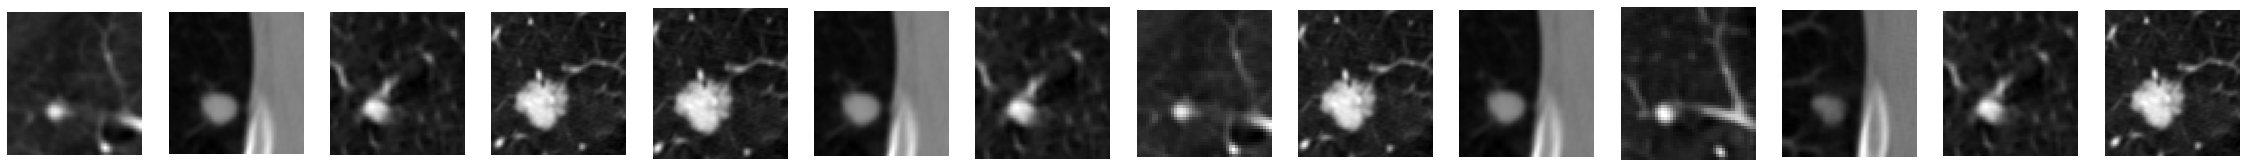

In [54]:
pid = 'LIDC-IDRI-0018'
show_all_nodules(pid, 1) #2/3/

In [ ]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0018/01-01-2000-90263/3000550.000000-10592"
only_nodule_slices = preprocess_patient(data_path)

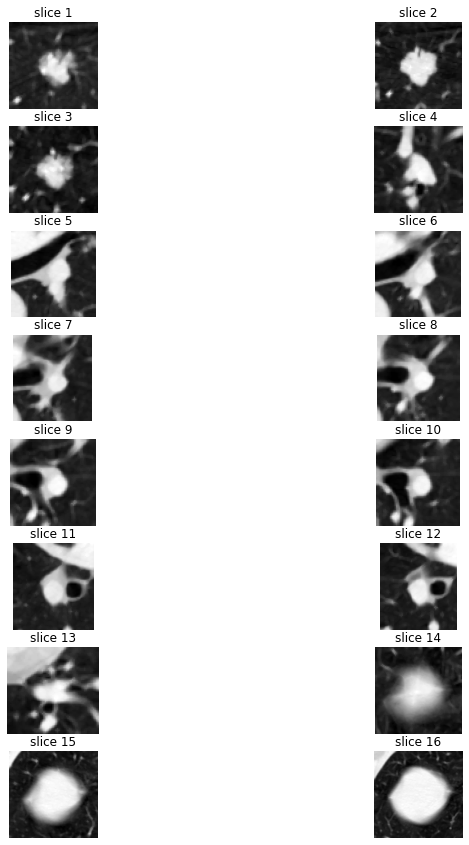

In [60]:
sample_stack(only_nodule_slices)

# Test simple rule-based system and feature extraction 

- obtain manually annotated nodule features from the pylidc database and compare with results from IP software
- test on patient ID 0001
- Compare nodule feature results (diameter, area and spiculation) and malignancy result

## From PYLIDC documentations: 

### Spiculation is denotated by: an int in range = {1,2,3,4,5}
#### Signifies the extent of spiculation present where:
- 1 : ‘No Spiculation’
- 2 : ‘Nearly No Spiculation’
- 3 : ‘Medium Spiculation’
- 4 : ‘Near Marked Spiculation’
- 5 : ‘Marked Spiculation’

### Malignancy is denotated by: an int in range = {1,2,3,4,5}
#### Subjective assessment of the likelihood of malignancy, assuming the scan originated from a 60-year-old male smoker, where:
- 1 : ‘Highly Unlikely’
- 2 : ‘Moderately Unlikely’
- 3 : ‘Indeterminate’
- 4 : ‘Moderately Suspicious’
- 5 : ‘Highly Suspicious’

Loading dicom files ... This may take a moment.
Annotation  1
Malignancy:  Highly Suspicious - 5
Spiculation:  Near Marked Spiculation - 4

Annotation  2
Malignancy:  Highly Suspicious - 5
Spiculation:  Marked Spiculation - 5

Annotation  3
Malignancy:  Highly Suspicious - 5
Spiculation:  Medium Spiculation - 3

Annotation  4
Malignancy:  Moderately Suspicious - 4
Spiculation:  Marked Spiculation - 5



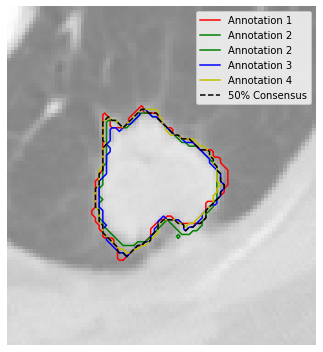

In [62]:
# Get nodule annotations from pylidc for PI 0001

pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[0]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

i = 1
for ann in anns:
    print("Annotation ", i)
    print("Malignancy: ", ann.Malignancy, "-", ann.malignancy)
    print("Spiculation: ", ann.Spiculation, "-", ann.spiculation)
    print()
    i += 1

ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

As can be shown in the slice above with annotations marked from pylidc, there are 4 annotations per slice. 
Get the average of the annotations for all features in order to compare with result generated from ip_software

In [65]:
get_average_annotation(anns)

Malignancy:  4.75
Spiculation:  4.25


Perform ip algorithm on PID0001 to obtain the ip software results

In [ ]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192"
only_nodule_slices = preprocess_patient(data_path)

5


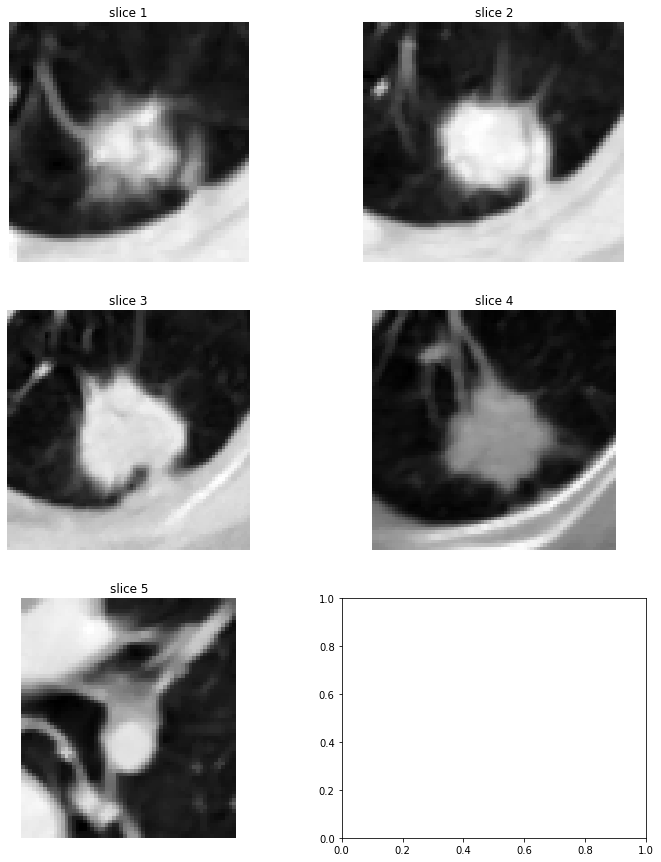

In [68]:
print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

Take slice 3 (index 2) and put into rule-based system for feature extraction and rule-based explanation

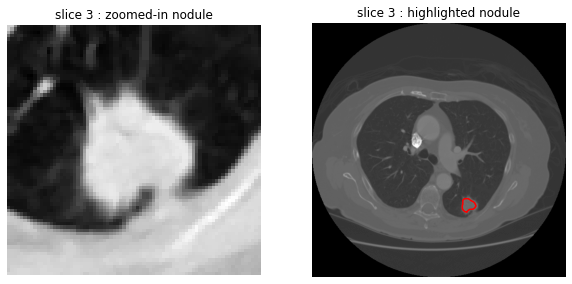

Nodule is strongly speculated to be malignant because diameter of nodule >=3mm and its spiculation is spiky
Area of Nodule: 37.802343740474996
Diameter of Nodule: 7.436114288783183
Solidity of Nodule: 0.9490333919156415
Spiculation: 0.4984317553975197


In [69]:
rule_based(only_nodule_slices[2], 2)

Compare results obtained.

It can be seen that the average consensus among the pylidc annotations is such that:
- Malignancy:  4.75
- Spiculation:  4.25

Based on their specified range (as mentioned above), since both values are >4, this is equivalent to the nodule being Highly Suspicious malignancy and Near Marked Spiculation.

Compare with the assumption made by the simple rule-based system (malignant and spiculated), this shows that the simple rule-based system produced a result that is similar to the pylidc annotations (accurate result)